In [1]:
import torch
from torch import nn, Tensor
import numpy as np
from torchvision.utils import save_image

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
import torchvision

img_size = 32

transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

images = torchvision.datasets.MNIST(root='./mnist_data', train=True, download=True, transform=transform)

In [3]:
BATCH_SIZE = 64
dataloader = torch.utils.data.DataLoader(images, batch_size=BATCH_SIZE, shuffle=True)

# 2. Model

In [4]:
channels = 1
img_shape = (channels, img_size, img_size)
latent_dim = 100

In [5]:
a = torch.randn(64, 3, 128, 128)
a = nn.Conv2d(3, 4, kernel_size=3, stride=2, padding=1)(a)
a.shape

torch.Size([64, 4, 64, 64])

In [6]:
class Generator(nn.Module):
    def __init__(self):
      super().__init__()
      self.init_size = 8
      self.fc = nn.Linear(latent_dim, 128*8*8)
      self.conv_blocks = nn.Sequential(
          nn.BatchNorm2d(128),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 128, 3, padding=1),

          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Upsample(scale_factor=2),
          nn.Conv2d(128, 64, 3, padding=1),

          nn.BatchNorm2d(64),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Conv2d(64, channels, kernel_size=3, padding=1),
          nn.Tanh()
      )
    def forward(self, z):
      x = self.fc(z)
      x = x.view(x.shape[0], 128, self.init_size, self.init_size)
      img = self.conv_blocks(x)
      return img

In [13]:
class Descriminator(nn.Module):
  def __init__(self):
     super().__init__()
     self.model = nn.Sequential(
         nn.Conv2d(channels, 16, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True),

         nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True),

         nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True),

         nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
         nn.LeakyReLU(0.2, inplace=True)
     )
     self.adv_layer = nn.Sequential(
         nn.Linear(128*2*2, 1),
         nn.Sigmoid()
     )
  def forward(self, img):
    x = self.model(img)
    x = x.view(x.shape[0], -1)
    validity = self.adv_layer(x)
    return validity

In [14]:
generator = Generator()
discriminator = Descriminator()

In [15]:
generator.to(device)

Generator(
  (fc): Linear(in_features=100, out_features=8192, bias=True)
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode='nearest')
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode='nearest')
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [16]:
discriminator.to(device)

Descriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (adv_layer): Sequential(
    (0): Linear(in_features=512, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# 3. Training

In [17]:
import os
os.makedirs('images', exist_ok=True)

save_interval = 10


In [18]:
EPOCHS = 60

optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0001)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

hist = {
        "train_G_loss": [],
        "train_D_loss": [],
    }

for epoch in range(EPOCHS):
    running_G_loss = 0.0
    running_D_loss = 0.0

    for i, (imgs, _) in enumerate(dataloader):

        real_imgs = imgs.to(device)
        real_labels = torch.ones(imgs.shape[0], 1).to(device)
        fake_labels = torch.zeros(imgs.shape[0], 1).to(device)

        # --- Train Generator ---
        optimizer_G.zero_grad()
        # Noise input for Generator
        z = torch.randn((imgs.shape[0], latent_dim)).to(device)

        gen_imgs = generator(z)
        G_loss = criterion(discriminator(gen_imgs), real_labels)
        running_G_loss += G_loss.item()

        G_loss.backward()
        optimizer_G.step()

        # --- Train Discriminator ---
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(gen_imgs.detach()), fake_labels)
        D_loss = (real_loss + fake_loss) / 2
        running_D_loss += D_loss.item()

        D_loss.backward()
        optimizer_D.step()

    epoch_G_loss = running_G_loss / len(dataloader)
    epoch_D_loss = running_D_loss / len(dataloader)

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Train G Loss: {epoch_G_loss:.4f}, Train D Loss: {epoch_D_loss:.4f}")

    hist["train_G_loss"].append(epoch_G_loss)
    hist["train_D_loss"].append(epoch_D_loss)

    if epoch % save_interval == 0:
        save_image(gen_imgs.data[:24], f"images/epoch_{epoch}.png", nrow=5, normalize=True)


Epoch [1/60], Train G Loss: 0.8291, Train D Loss: 0.6506
Epoch [2/60], Train G Loss: 0.9092, Train D Loss: 0.6231
Epoch [3/60], Train G Loss: 1.0610, Train D Loss: 0.5648
Epoch [4/60], Train G Loss: 1.3707, Train D Loss: 0.4629
Epoch [5/60], Train G Loss: 1.4343, Train D Loss: 0.4477
Epoch [6/60], Train G Loss: 1.4855, Train D Loss: 0.4479
Epoch [7/60], Train G Loss: 1.5408, Train D Loss: 0.4370
Epoch [8/60], Train G Loss: 1.5587, Train D Loss: 0.4287
Epoch [9/60], Train G Loss: 1.5902, Train D Loss: 0.4248
Epoch [10/60], Train G Loss: 1.5889, Train D Loss: 0.4235
Epoch [11/60], Train G Loss: 1.6153, Train D Loss: 0.4189
Epoch [12/60], Train G Loss: 1.6543, Train D Loss: 0.4089
Epoch [13/60], Train G Loss: 1.7083, Train D Loss: 0.3982
Epoch [14/60], Train G Loss: 1.7583, Train D Loss: 0.3842
Epoch [15/60], Train G Loss: 1.8103, Train D Loss: 0.3783
Epoch [16/60], Train G Loss: 1.8636, Train D Loss: 0.3625
Epoch [17/60], Train G Loss: 1.9182, Train D Loss: 0.3557
Epoch [18/60], Train G 

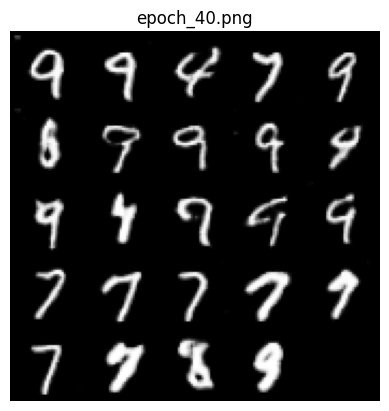

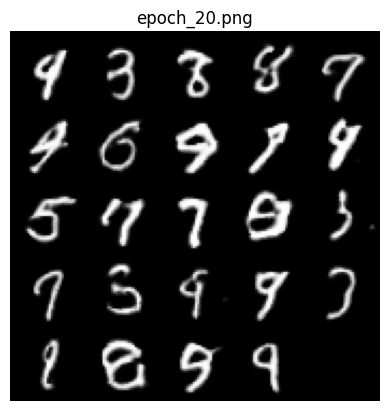

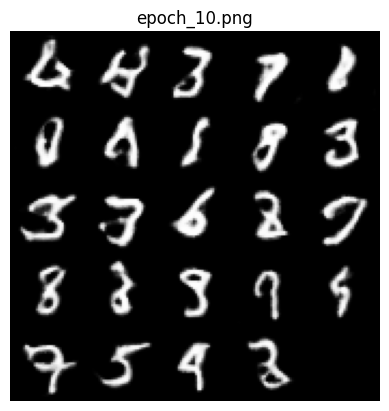

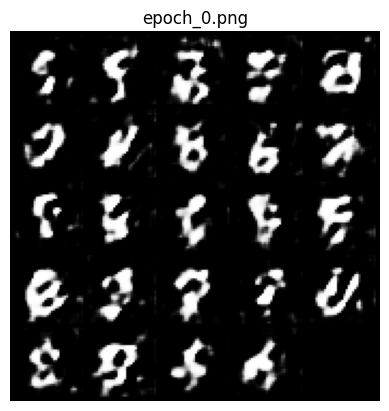

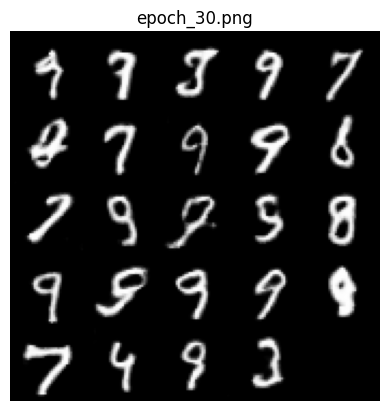

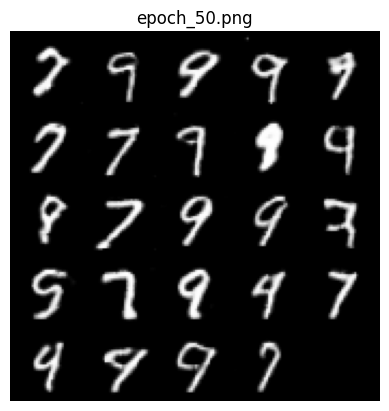

In [19]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Path to your image folder
folder_path = '/content/images'

# Get list of all files in the folder
images = os.listdir(folder_path)

# Create subplots based on number of images

# Iterate and plot each image
for i, image_name in enumerate(images):
    # Construct full image path
    image_path = os.path.join(folder_path, image_name)
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_name)
    plt.show()

